In [1]:
!pip install -q kaggle

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [3]:
train_directory="/content/dataset/Emotions Dataset/Emotions Dataset/train"
# validation_directory="/content/dataset/Emotions Dataset/Emotions Dataset/test"
val_directory="/content/dataset/Emotions Dataset/Emotions Dataset/test"

CLASS_NAMES=["angry","happy","sad"]
CONFIGURATION={
    "BATCH_SIZE":32,
    "IM_SIZE":256,
    "LEARNING_RATE":0.003,
    "N_EPOCHS":7,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":100,
    "N_DENSE_2":10, #no.of o/p in other dense layer
    "NUM_CLASSES":3,
}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# !kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes


 94% 291M/309M [00:02<00:00, 183MB/s]
100% 309M/309M [00:02<00:00, 145MB/s]


In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [8]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99, #so that suffle will be same all time
    # validation_split=0.2, #since need to divide automatically to training and validation
    # subset="training",

)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset=tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [10]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

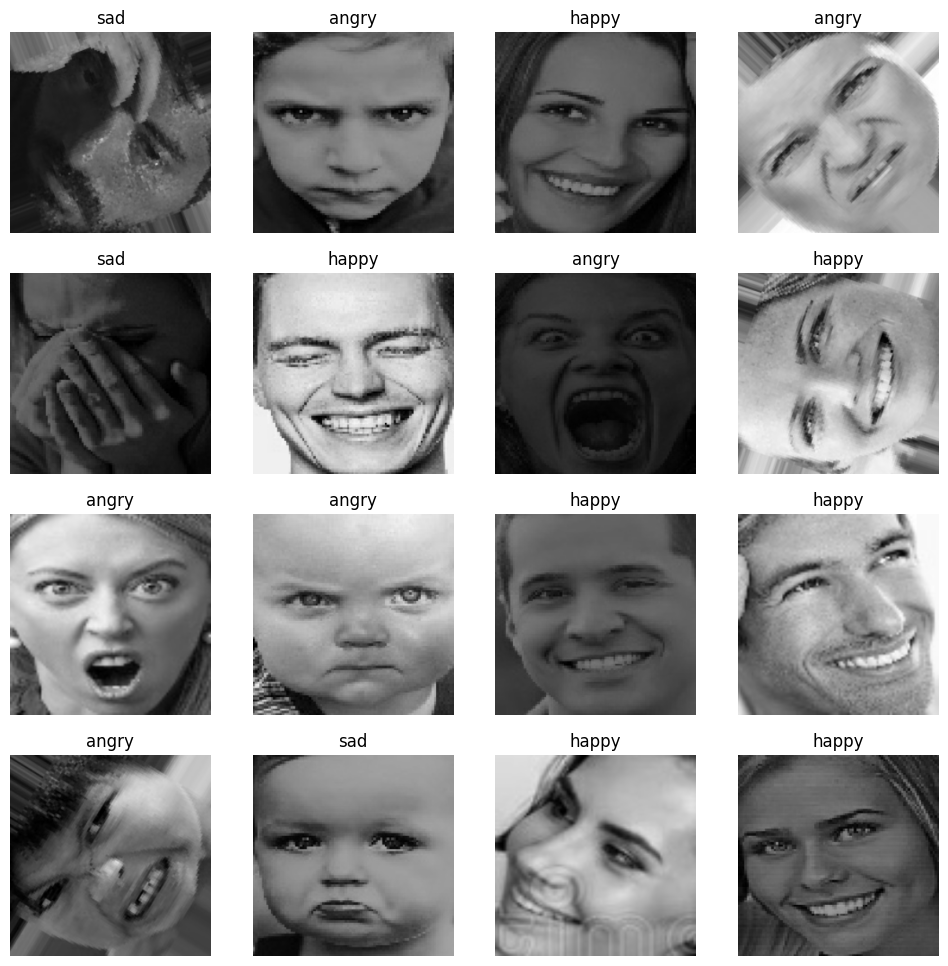

In [11]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [12]:
augment_layers=tf.keras.Sequential([
    RandomRotation(factor=(-0.025,0.025),),  #limiting to 9 degrees rotation not more than that, since 0.025.(if the angle was not limited then images are being upside down which is lading to poor performence)
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

In [13]:
def augment_layer(image,label):
  return augment_layers(image,training=True),label

In [14]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w


In [15]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [16]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [17]:
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [18]:
validation_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
resize_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),Rescaling(1./255),
    ])

**CustomConv2D**

In [20]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

 **ResidualBlock**

In [21]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)



**complete** **network**

In [22]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)


In [23]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()


Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

## Training

In [24]:
checkpoint_callback=ModelCheckpoint(
    'best_weights', #specifying the folder. (since we are goin to save these models in tensorflow format)
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [25]:
loss_function=CategoricalCrossentropy()

In [26]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

In [27]:
resnet_34.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']*10),
    loss=loss_function,
    metrics=metrics
)

In [31]:
history=resnet_34.fit(
    training_dataset,
    validation_data=validation_dataset,
    # epochs=CONFIGURATION["N_EPOCHS"],
    epochs=60,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/60
213/213 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.5280 - top_k_accuracy: 0.8189
Epoch 1: val_accuracy did not improve from 0.51317
213/213 [==============================] - 120s 550ms/step - loss: 0.9877 - accuracy: 0.5280 - top_k_accuracy: 0.8189 - val_loss: 3.8861 - val_accuracy: 0.4772 - val_top_k_accuracy: 0.7845
Epoch 2/60
213/213 [==============================] - ETA: 0s - loss: 0.9813 - accuracy: 0.5441 - top_k_accuracy: 0.8262
Epoch 2: val_accuracy did not improve from 0.51317
213/213 [==============================] - 121s 561ms/step - loss: 0.9813 - accuracy: 0.5441 - top_k_accuracy: 0.8262 - val_loss: 1.3485 - val_accuracy: 0.4759 - val_top_k_accuracy: 0.7673
Epoch 3/60
213/213 [==============================] - ETA: 0s - loss: 0.9411 - accuracy: 0.5742 - top_k_accuracy: 0.8372
Epoch 3: val_accuracy did not improve from 0.51317
213/213 [==============================] - 119s 552ms/step - loss: 0.9411 - accuracy: 0.5742 - top_k_accur

213/213 [==============================] - 143s 660ms/step - loss: 0.9290 - accuracy: 0.5730 - top_k_accuracy: 0.8410 - val_loss: 0.9397 - val_accuracy: 0.5869 - val_top_k_accuracy: 0.8187
Epoch 5/60
213/213 [==============================] - ETA: 0s - loss: 0.8942 - accuracy: 0.6102 - top_k_accuracy: 0.8542
Epoch 5: val_accuracy did not improve from 0.58692
213/213 [==============================] - 118s 548ms/step - loss: 0.8942 - accuracy: 0.6102 - top_k_accuracy: 0.8542 - val_loss: 1.3010 - val_accuracy: 0.5162 - val_top_k_accuracy: 0.8068
Epoch 6/60
213/213 [==============================] - ETA: 0s - loss: 0.9325 - accuracy: 0.5808 - top_k_accuracy: 0.8328
Epoch 6: val_accuracy did not improve from 0.58692
213/213 [==============================] - 118s 544ms/step - loss: 0.9325 - accuracy: 0.5808 - top_k_accuracy: 0.8328 - val_loss: 1.3450 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7744
Epoch 7/60
213/213 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 

213/213 [==============================] - 139s 649ms/step - loss: 0.8628 - accuracy: 0.6347 - top_k_accuracy: 0.8684 - val_loss: 0.8338 - val_accuracy: 0.6225 - val_top_k_accuracy: 0.8569
Epoch 9/60
213/213 [==============================] - ETA: 0s - loss: 0.8455 - accuracy: 0.6433 - top_k_accuracy: 0.8732
Epoch 9: val_accuracy did not improve from 0.62248
213/213 [==============================] - 118s 547ms/step - loss: 0.8455 - accuracy: 0.6433 - top_k_accuracy: 0.8732 - val_loss: 1.2751 - val_accuracy: 0.5092 - val_top_k_accuracy: 0.8288
Epoch 10/60
213/213 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.6645 - top_k_accuracy: 0.8781
Epoch 10: val_accuracy did not improve from 0.62248
213/213 [==============================] - 117s 543ms/step - loss: 0.8284 - accuracy: 0.6645 - top_k_accuracy: 0.8781 - val_loss: 0.9041 - val_accuracy: 0.5702 - val_top_k_accuracy: 0.8376
Epoch 11/60
213/213 [==============================] - ETA: 0s - loss: 0.8277 - accurac

213/213 [==============================] - 140s 651ms/step - loss: 0.8142 - accuracy: 0.6810 - top_k_accuracy: 0.8892 - val_loss: 12.0973 - val_accuracy: 0.6607 - val_top_k_accuracy: 0.8964
Epoch 13/60
213/213 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.6972 - top_k_accuracy: 0.8962
Epoch 13: val_accuracy did not improve from 0.66067
213/213 [==============================] - 117s 541ms/step - loss: 0.7944 - accuracy: 0.6972 - top_k_accuracy: 0.8962 - val_loss: 77.6057 - val_accuracy: 0.5114 - val_top_k_accuracy: 0.8266
Epoch 14/60
213/213 [==============================] - ETA: 0s - loss: 0.7838 - accuracy: 0.6973 - top_k_accuracy: 0.8992
Epoch 14: val_accuracy did not improve from 0.66067
213/213 [==============================] - 117s 541ms/step - loss: 0.7838 - accuracy: 0.6973 - top_k_accuracy: 0.8992 - val_loss: 0.8375 - val_accuracy: 0.6348 - val_top_k_accuracy: 0.8683
Epoch 15/60
213/213 [==============================] - ETA: 0s - loss: 0.7883 - acc

213/213 [==============================] - 143s 666ms/step - loss: 0.7353 - accuracy: 0.7388 - top_k_accuracy: 0.9087 - val_loss: 0.6427 - val_accuracy: 0.7388 - val_top_k_accuracy: 0.9153
Epoch 20/60
213/213 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.7420 - top_k_accuracy: 0.9175
Epoch 20: val_accuracy did not improve from 0.73881
213/213 [==============================] - 120s 554ms/step - loss: 0.7247 - accuracy: 0.7420 - top_k_accuracy: 0.9175 - val_loss: 353.7317 - val_accuracy: 0.6277 - val_top_k_accuracy: 0.8705
Epoch 21/60
213/213 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7514 - top_k_accuracy: 0.9198
Epoch 21: val_accuracy did not improve from 0.73881
213/213 [==============================] - 119s 552ms/step - loss: 0.7106 - accuracy: 0.7514 - top_k_accuracy: 0.9198 - val_loss: 0.6463 - val_accuracy: 0.7309 - val_top_k_accuracy: 0.9104
Epoch 22/60
213/213 [==============================] - ETA: 0s - loss: 0.7092 - acc

213/213 [==============================] - 132s 615ms/step - loss: 0.6986 - accuracy: 0.7561 - top_k_accuracy: 0.9240 - val_loss: 640028.7500 - val_accuracy: 0.7419 - val_top_k_accuracy: 0.9065
Epoch 24/60
213/213 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.7682 - top_k_accuracy: 0.9247
Epoch 24: val_accuracy improved from 0.74188 to 0.76997, saving model to best_weights


213/213 [==============================] - 135s 627ms/step - loss: 0.6923 - accuracy: 0.7682 - top_k_accuracy: 0.9247 - val_loss: 559.5466 - val_accuracy: 0.7700 - val_top_k_accuracy: 0.9249
Epoch 25/60
213/213 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.7713 - top_k_accuracy: 0.9318
Epoch 25: val_accuracy did not improve from 0.76997
213/213 [==============================] - 114s 528ms/step - loss: 0.6779 - accuracy: 0.7713 - top_k_accuracy: 0.9318 - val_loss: 0.6307 - val_accuracy: 0.7335 - val_top_k_accuracy: 0.9232
Epoch 26/60
213/213 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.7708 - top_k_accuracy: 0.9278
Epoch 26: val_accuracy did not improve from 0.76997
213/213 [==============================] - 114s 524ms/step - loss: 0.6856 - accuracy: 0.7708 - top_k_accuracy: 0.9278 - val_loss: 2140.7410 - val_accuracy: 0.7217 - val_top_k_accuracy: 0.9214
Epoch 27/60
213/213 [==============================] - ETA: 0s - loss: 0.6623 - 

213/213 [==============================] - 137s 637ms/step - loss: 0.6735 - accuracy: 0.7819 - top_k_accuracy: 0.9338 - val_loss: 630.2984 - val_accuracy: 0.7735 - val_top_k_accuracy: 0.9293
Epoch 35/60
213/213 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.8194 - top_k_accuracy: 0.9482
Epoch 35: val_accuracy did not improve from 0.77349
213/213 [==============================] - 115s 531ms/step - loss: 0.6090 - accuracy: 0.8194 - top_k_accuracy: 0.9482 - val_loss: 0.6248 - val_accuracy: 0.7480 - val_top_k_accuracy: 0.9100
Epoch 36/60
213/213 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.8076 - top_k_accuracy: 0.9446
Epoch 36: val_accuracy did not improve from 0.77349
213/213 [==============================] - 114s 530ms/step - loss: 0.6255 - accuracy: 0.8076 - top_k_accuracy: 0.9446 - val_loss: 3397.9758 - val_accuracy: 0.6475 - val_top_k_accuracy: 0.8982
Epoch 37/60
213/213 [==============================] - ETA: 0s - loss: 0.6148 - 

213/213 [==============================] - 138s 643ms/step - loss: 0.6148 - accuracy: 0.8176 - top_k_accuracy: 0.9444 - val_loss: 48.7916 - val_accuracy: 0.7954 - val_top_k_accuracy: 0.9429
Epoch 38/60
213/213 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.8297 - top_k_accuracy: 0.9503
Epoch 38: val_accuracy improved from 0.79543 to 0.80948, saving model to best_weights


213/213 [==============================] - 137s 636ms/step - loss: 0.6045 - accuracy: 0.8297 - top_k_accuracy: 0.9503 - val_loss: 4920.6665 - val_accuracy: 0.8095 - val_top_k_accuracy: 0.9407
Epoch 39/60
213/213 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.8350 - top_k_accuracy: 0.9544
Epoch 39: val_accuracy did not improve from 0.80948
213/213 [==============================] - 115s 532ms/step - loss: 0.5825 - accuracy: 0.8350 - top_k_accuracy: 0.9544 - val_loss: 0.5924 - val_accuracy: 0.7564 - val_top_k_accuracy: 0.9219
Epoch 40/60
213/213 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.8456 - top_k_accuracy: 0.9584
Epoch 40: val_accuracy did not improve from 0.80948
213/213 [==============================] - 114s 527ms/step - loss: 0.5756 - accuracy: 0.8456 - top_k_accuracy: 0.9584 - val_loss: 1173.9025 - val_accuracy: 0.7976 - val_top_k_accuracy: 0.9363
Epoch 41/60
213/213 [==============================] - ETA: 0s - loss: 0.5930 -

213/213 [==============================] - 136s 632ms/step - loss: 0.5310 - accuracy: 0.8675 - top_k_accuracy: 0.9635 - val_loss: 631626.8125 - val_accuracy: 0.8187 - val_top_k_accuracy: 0.9438
Epoch 51/60
213/213 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.8720 - top_k_accuracy: 0.9651
Epoch 51: val_accuracy improved from 0.81870 to 0.82221, saving model to best_weights


213/213 [==============================] - 136s 631ms/step - loss: 0.5267 - accuracy: 0.8720 - top_k_accuracy: 0.9651 - val_loss: 2815.4614 - val_accuracy: 0.8222 - val_top_k_accuracy: 0.9456
Epoch 52/60
213/213 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.8690 - top_k_accuracy: 0.9654
Epoch 52: val_accuracy did not improve from 0.82221
213/213 [==============================] - 114s 528ms/step - loss: 0.5328 - accuracy: 0.8690 - top_k_accuracy: 0.9654 - val_loss: 2742.5737 - val_accuracy: 0.6453 - val_top_k_accuracy: 0.8867
Epoch 53/60
213/213 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.8820 - top_k_accuracy: 0.9684
Epoch 53: val_accuracy did not improve from 0.82221
213/213 [==============================] - 114s 527ms/step - loss: 0.5288 - accuracy: 0.8820 - top_k_accuracy: 0.9684 - val_loss: 7165.5063 - val_accuracy: 0.7555 - val_top_k_accuracy: 0.9056
Epoch 54/60
213/213 [==============================] - ETA: 0s - loss: 0.529

213/213 [==============================] - 137s 639ms/step - loss: 0.5291 - accuracy: 0.8800 - top_k_accuracy: 0.9706 - val_loss: 24.5908 - val_accuracy: 0.8288 - val_top_k_accuracy: 0.9478
Epoch 55/60
213/213 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.8731 - top_k_accuracy: 0.9682
Epoch 55: val_accuracy did not improve from 0.82880
213/213 [==============================] - 114s 528ms/step - loss: 0.5319 - accuracy: 0.8731 - top_k_accuracy: 0.9682 - val_loss: 131.6231 - val_accuracy: 0.7651 - val_top_k_accuracy: 0.9258
Epoch 56/60
213/213 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.8810 - top_k_accuracy: 0.9721
Epoch 56: val_accuracy did not improve from 0.82880
213/213 [==============================] - 113s 525ms/step - loss: 0.5263 - accuracy: 0.8810 - top_k_accuracy: 0.9721 - val_loss: 576.1286 - val_accuracy: 0.8073 - val_top_k_accuracy: 0.9368
Epoch 57/60
213/213 [==============================] - ETA: 0s - loss: 0.5396 - 

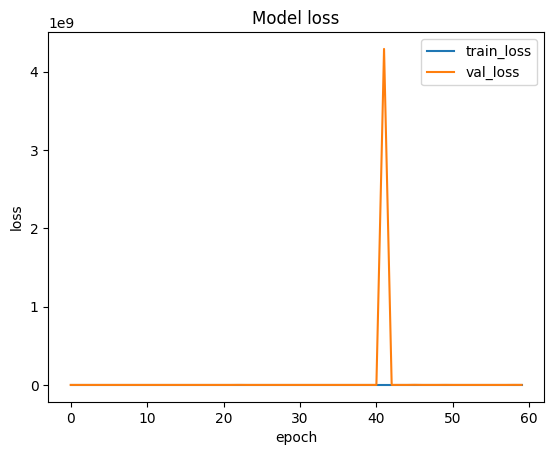

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])

plt.show()

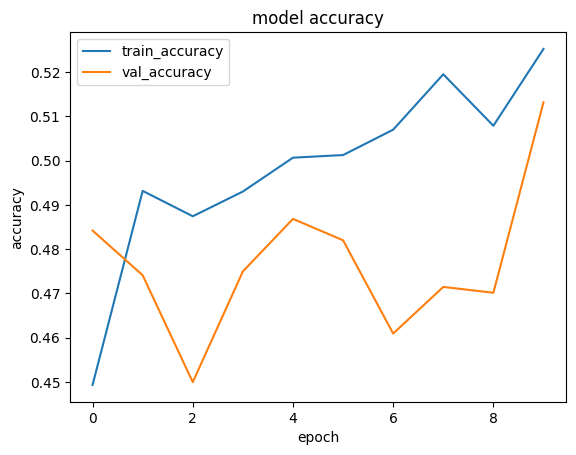

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
# legend() which is used to place a legend on the axis(like at a bottom side of the graph it (shows)names which line represents what)
plt.show()

## EVALUATION

In [ ]:
resnet_34.evaluate('best_weights')

In [36]:
resnet_34.evaluate(validation_dataset)

72/72 [==============================] - 5s 66ms/step - loss: 466963.9062 - accuracy: 0.7015 - top_k_accuracy: 0.9263


[466963.90625, 0.7014925479888916, 0.9262511134147644]

## TESTING

In [43]:
test_image=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")
im=tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
print(CLASS_NAMES[tf.argmax(resnet_34(im),axis=-1).numpy()[0]])

happy


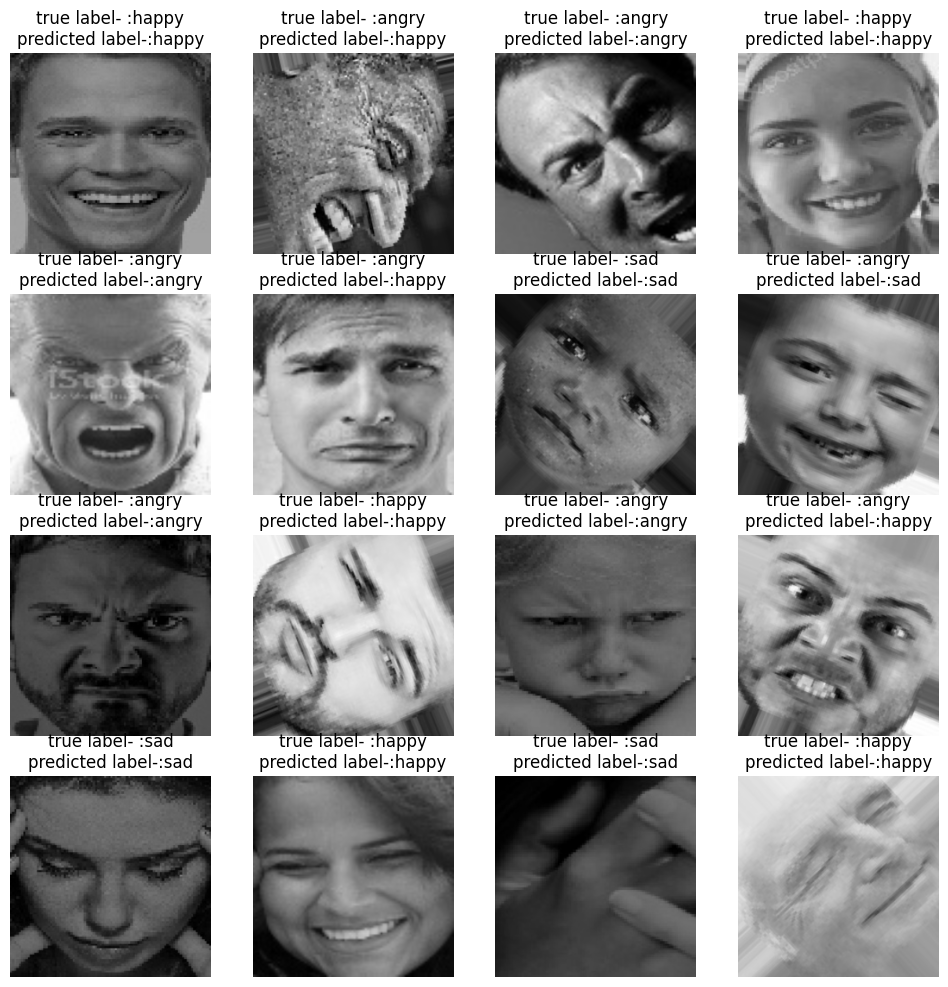

In [40]:
# for i in validation_dataset.take(1):
#   print(i)

plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title("true label- :"+CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()] +"\n" +"predicted label-:"+CLASS_NAMES[tf.argmax(resnet_34(tf.expand_dims(images[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

In [45]:
predicted=[]
labels=[]
for im,label in validation_dataset:
  predicted.append(resnet_34(im))
  labels.append(label.numpy())


In [46]:
pred=np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()]) #to not consider last batch we keep [:-1] since if we have total 98 items having given batch size as 32 then 32*3=96 and remaing 3 items in other batch so skip that and againn we will concat that which havi 2 elements after flatening it seperately
lab=np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

[[385  40  90]
 [ 29 885  92]
 [ 63  47 647]]


Text(0.5, 58.7222222222222, 'predicted')

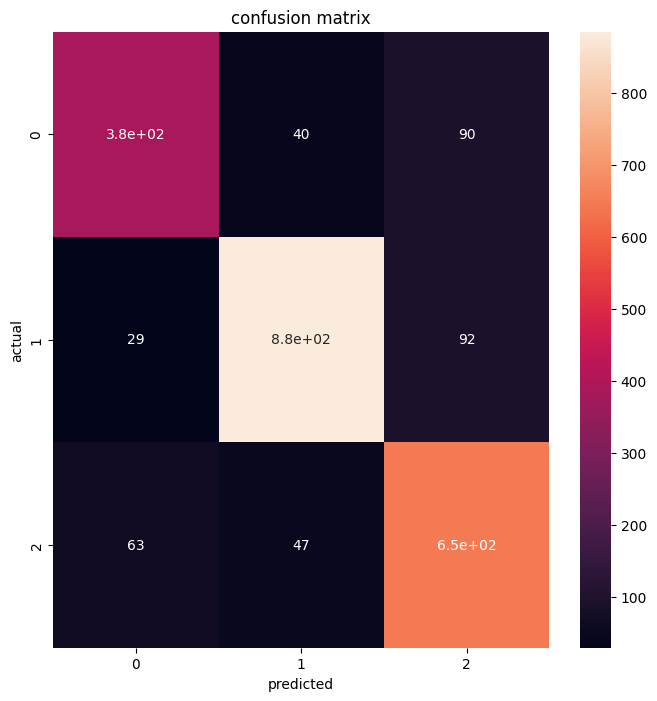

In [47]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,)
plt.title('confusion matrix')
plt.ylabel("actual")
plt.xlabel('predicted')

<Axes: >

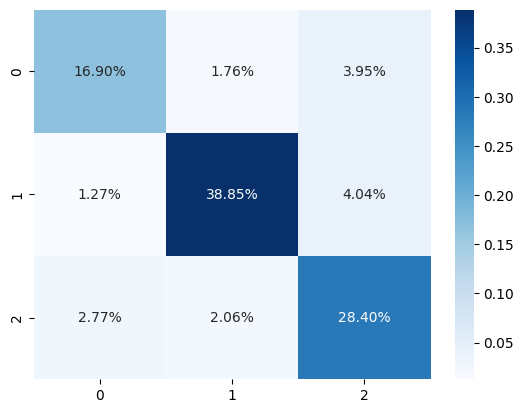

In [48]:
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%',cmap="Blues")